<a href="https://colab.research.google.com/github/AshwinDeshpande96/Hierarchical-Softmax/blob/master/hsm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras import backend as K
from copy import copy
from random import shuffle
import numpy as np
import decimal
import tensorflow as tf

Using TensorFlow backend.


In [0]:

class Tree:
    def __init__(self, leaf_num):
        self.decision = {0:1, 1:-1}
        self.index = 0
        
        arr = []
        arr2 = []

        for path, base, decision, leaf in self.get_decision(self.create_random_tree(leaf_num)):
            temporary = np.zeros((1,leaf_num-1), dtype='float32')
            temporary2 = np.ones((1,leaf_num-1), dtype='float32')
            
            np.put(temporary, path, decision)
            np.put(temporary2, path, base)
            
            arr.append(temporary)
            arr2.append(temporary2)
        self.index = 0    
        self.decision = tf.convert_to_tensor(np.array(arr).reshape((leaf_num, leaf_num-1)), preferred_dtype='float32')
        self.base = tf.convert_to_tensor(np.array(arr2).reshape((leaf_num, leaf_num-1)), preferred_dtype='float32')
        
        
    def create_random_tree(self, output_dim):
        outputs = list(range(output_dim))
        outputs = copy(outputs)
        #shuffle(outputs)
    
        while len(outputs) > 2:
            temp_outputs = []
            for i in range(0, len(outputs), 2):
                if len(outputs) - (i+1) > 0:
                    temp_outputs.append([outputs[i], outputs[i+1]])
                else:
                    temp_outputs.append(outputs[i])
            outputs = temp_outputs
        return outputs

    def get_decision(self, tree):
        temp_i = self.index
        self.index += 1
        for i, subtree in enumerate(tree):
            #temp_i = self.index
            if type(subtree) == list:
                for path, base, decision_list, value in self.get_decision(subtree):
                    yield [temp_i] + path, [i]+base, [self.decision[i]]+decision_list, value
            else:
                yield [temp_i], [i], [self.decision[i]],subtree 
   


# Visualization

In [0]:
import tensorflow as tf
from keras import backend as K
import numpy as np
def hierarchical_softmax(inp, tree):
    x1 = tf.multiply(tree.decision, inp)
    x1 = tree.base + x1
    x1 = tf.log(x1)
    ones = tf.ones(shape=[inp.get_shape()[-1], 1])
    x1 = K.dot(x1, ones)
    return tf.math.exp(x1)
def hierarchical_softmax2(inp, tree):
    x1 = tf.multiply(tree.decision, inp)
    x1 = tree.base + x1
    return tf.math.reduce_prod(x1, axis=1)

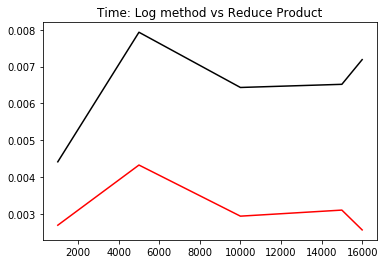

In [0]:
import matplotlib.pyplot as plt
import time
import gc

index = []
smax_speed = []
hsmax_speed = []

for num_l in [1000, 5000, 10000, 15000, 16000]:

    input1 = tf.convert_to_tensor(np.random.rand(1,num_l-1).astype('float32'))
    t = Tree(num_l)
    
    smax_s = time.time()
    hierarchical_softmax(input1, t)
    hsmax_s = smax_e = time.time()
    hierarchical_softmax2(input1, t)
    hsmax_e = time.time()
    
    smax_time = smax_e - smax_s
    hsmax_time = hsmax_e - hsmax_s
    
    smax_speed.append(smax_time)
    hsmax_speed.append(hsmax_time)
    index.append(num_l)
    gc.collect()    
plt.plot(index, smax_speed, color='black')
plt.plot(index, hsmax_speed, color='red')
plt.title('Time: Log method vs Reduce Product')
plt.show()

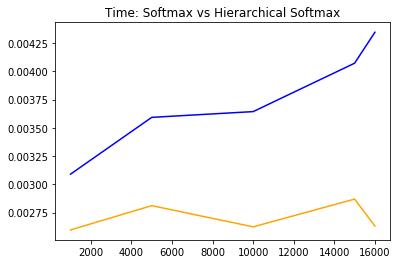

In [0]:
import matplotlib.pyplot as plt
import time
import gc

index = []
smax_speed = []
custom_speed = []

for num_l in [1000, 5000, 10000, 15000, 16000]:

    input1 = tf.convert_to_tensor(np.random.rand(1,num_l-1).astype('float32'))
    t = Tree(num_l)
    
    smax_s = time.time()
    a = tf.math.exp(input1)
    a/tf.math.reduce_sum(a)
    custom_s = smax_e = time.time()
    hierarchical_softmax2(input1, t)
    custom_e = time.time()
    
    smax_time = smax_e - smax_s
    custom_time = custom_e-custom_s
    
    smax_speed.append(smax_time)
    custom_speed.append(custom_time)
    index.append(num_l)
    gc.collect()    
plt.plot(index, smax_speed, color='blue')
plt.plot(index, custom_speed, color='orange')
plt.title('Time: Softmax vs Hierarchical Softmax')
plt.show()

In [0]:
import matplotlib.pyplot as plt
import time
import gc

index = []
smax_speed = []
custom_speed = []

for num_l in [1000, 5000, 10000, 15000, 16000]:

    input1 = tf.convert_to_tensor(np.random.rand(1,num_l-1).astype('float32'))
    t = Tree(num_l)
    
    smax_s = time.time()
    #a = tf.math.exp(input1)
    #a/tf.math.reduce_sum(a)
    K.prod(t.base+tf.multiply(t.decision, input1), axis=1)
    custom_s = smax_e = time.time()
    tf.math.reduce_prod(t.base+tf.multiply(t.decision, input1), axis=1)
    custom_e = time.time()
    
    smax_time = smax_e - smax_s
    custom_time = custom_e-custom_s
    
    smax_speed.append(smax_time)
    custom_speed.append(custom_time)
    index.append(num_l)
    gc.collect()    

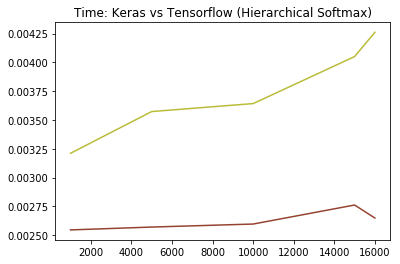

In [0]:
plt.plot(index, smax_speed, color='#babc38')
plt.plot(index, custom_speed, color='#964230')
plt.title('Time: Keras vs Tensorflow (Hierarchical Softmax)')
plt.show()

In [0]:
import matplotlib.pyplot as plt
import time
import gc

index = []
smax_speed = []
_smax_speed = []

for num_l in [1000, 5000, 10000]:
    gc.collect()
    input1 = tf.convert_to_tensor(np.random.rand(1,num_l-1).astype('float32'))
    t = Tree(num_l)
    
    smax_s = time.time()
    a = tf.math.exp(input1)
    a/tf.math.reduce_sum(a)
    _smax_s = smax_e = time.time()
    e = K.exp(input1 - K.max(input1, axis=-1, keepdims=True))
    e/K.sum(e, axis=-1, keepdims=True)
    _smax_e = time.time()
    
    smax_time = smax_e - smax_s
    _smax_time = _smax_e - _smax_s
    
    smax_speed.append(smax_time)
    _smax_speed.append(_smax_time)
    index.append(num_l)
    

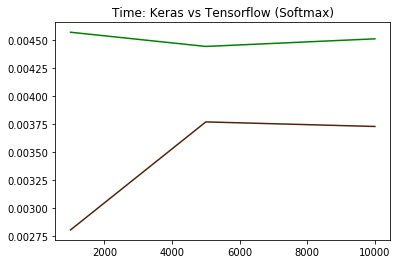

In [0]:
plt.plot(index, smax_speed, color='#4f250b')
plt.plot(index, _smax_speed, color='green')
plt.title('Time: Keras vs Tensorflow (Softmax)')
plt.show()

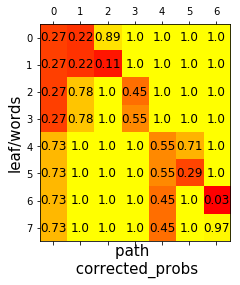

In [85]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
#ax.set_title("This is my title")
#ax.set_xlabel('\n\nSize of Vocabulary \n Fig-2: Predicted r_hat')
ax.set_xlabel('path \n corrected_probs', fontsize=15)
ax.set_ylabel('leaf/words', fontsize=15)
#fig.set_size_inches(18, 12)
#ax.set_title("Left Child Probabilities")
min_val, max_val = 0, 15
sess = tf.Session()
intersection_matrix = sess.run(base_prob)

intersection_matrix = np.around(intersection_matrix, decimals=2)
ax.matshow(intersection_matrix, cmap=plt.cm.autumn)

for i in xrange(intersection_matrix.shape[1]):
    for j in xrange(intersection_matrix.shape[0]):
        c = intersection_matrix[j,i]
        ax.text(i, j, str(c), va='center', ha='center', size='large')